### data preparation

#### read files

In [1]:
import pandas as pd

df = pd.read_csv('../data/survey_responses/cleaned_survey_responses.csv')

# subset required data
path_matrix = df[['hollywood', 'minion_land', 'far_far_away', 'lost_world', 'ancient_egypt', 'scifi_city', 'new_york']]
path_matrix = path_matrix[path_matrix.any(axis='columns')] #(33, 7)

#### data prep
all data required for analysis from this point will only refrerence target_entries

In [2]:
# subset full survey response of relevant data
target_rows = path_matrix.index.values.tolist()
target_entries = df.loc[target_rows]

# CREATING ORDERED SEQUENCES
# Function to sort a row and return ordered column names
def sort_row(row):
    return row.dropna().sort_values().index.tolist()

# Apply function row-wise
ordered_sequences = path_matrix.apply(sort_row, axis=1)

# concat ordered sequences to target_entries data for easy retrival
target_entries = pd.concat([target_entries, ordered_sequences], axis=1)
target_entries = target_entries.rename(columns={'Unnamed: 0' : 'response_id', 0:'sequences'})
print(target_entries.shape)
target_entries.head()


(33, 47)


,response_id,timestamp,visited_US,visit_freq,age,gender,monthly_income,nationality,companion,ride_pref,...,attraction_decision,top_expense,hollywood,minion_land,far_far_away,lost_world,ancient_egypt,scifi_city,new_york,sequences
93,93,22/02/2025 12:23:46,True,When on vacation,19-25 years old,Male,No income,singaporean/pr,Friends,medium,...,A mix of both of the above —some planned rides...,Transportation,6.0,NaN,5.0,4.0,3.0,2.0,1.0,"[new_york, scifi_city, ancient_egypt, lost_wor..."
94,94,22/02/2025 18:44:37,True,When on vacation,55 and above,Others,"$20,000 and above",russian,Family,no_rides,...,I stick to the few rides/attractions that I en...,Transportation,1.0,1.0,2.0,3.0,3.0,2.0,3.0,"[hollywood, minion_land, far_far_away, scifi_c..."
96,96,22/02/2025 18:58:00,True,Once every year,15-18 years old,Female,No income,singaporean/pr,"Friends, Family",medium,...,I decide based on which rides are closest to m...,Transportation,4.0,6.0,2.0,3.0,1.0,2.0,5.0,"[ancient_egypt, far_far_away, scifi_city, lost..."
98,98,22/02/2025 19:32:46,True,Once every year,19-25 years old,Female,Below $2000,singaporean/pr,"Couple (I go with my partner), Family",high,...,A mix of both of the above —some planned rides...,F&B,1.0,NaN,4.0,5.0,3.0,7.0,2.0,"[hollywood, new_york, ancient_egypt, far_far_a..."
99,99,22/02/2025 19:33:14,True,< Once every 3 years,19-25 years old,Female,Below $2000,singaporean/pr,Couple (I go with my partner),high,...,I decide based on which rides are closest to m...,Transportation,1.0,NaN,1.0,2.0,3.0,3.0,4.0,"[hollywood, far_far_away, lost_world, ancient_..."


### data exploration

#### guest paths

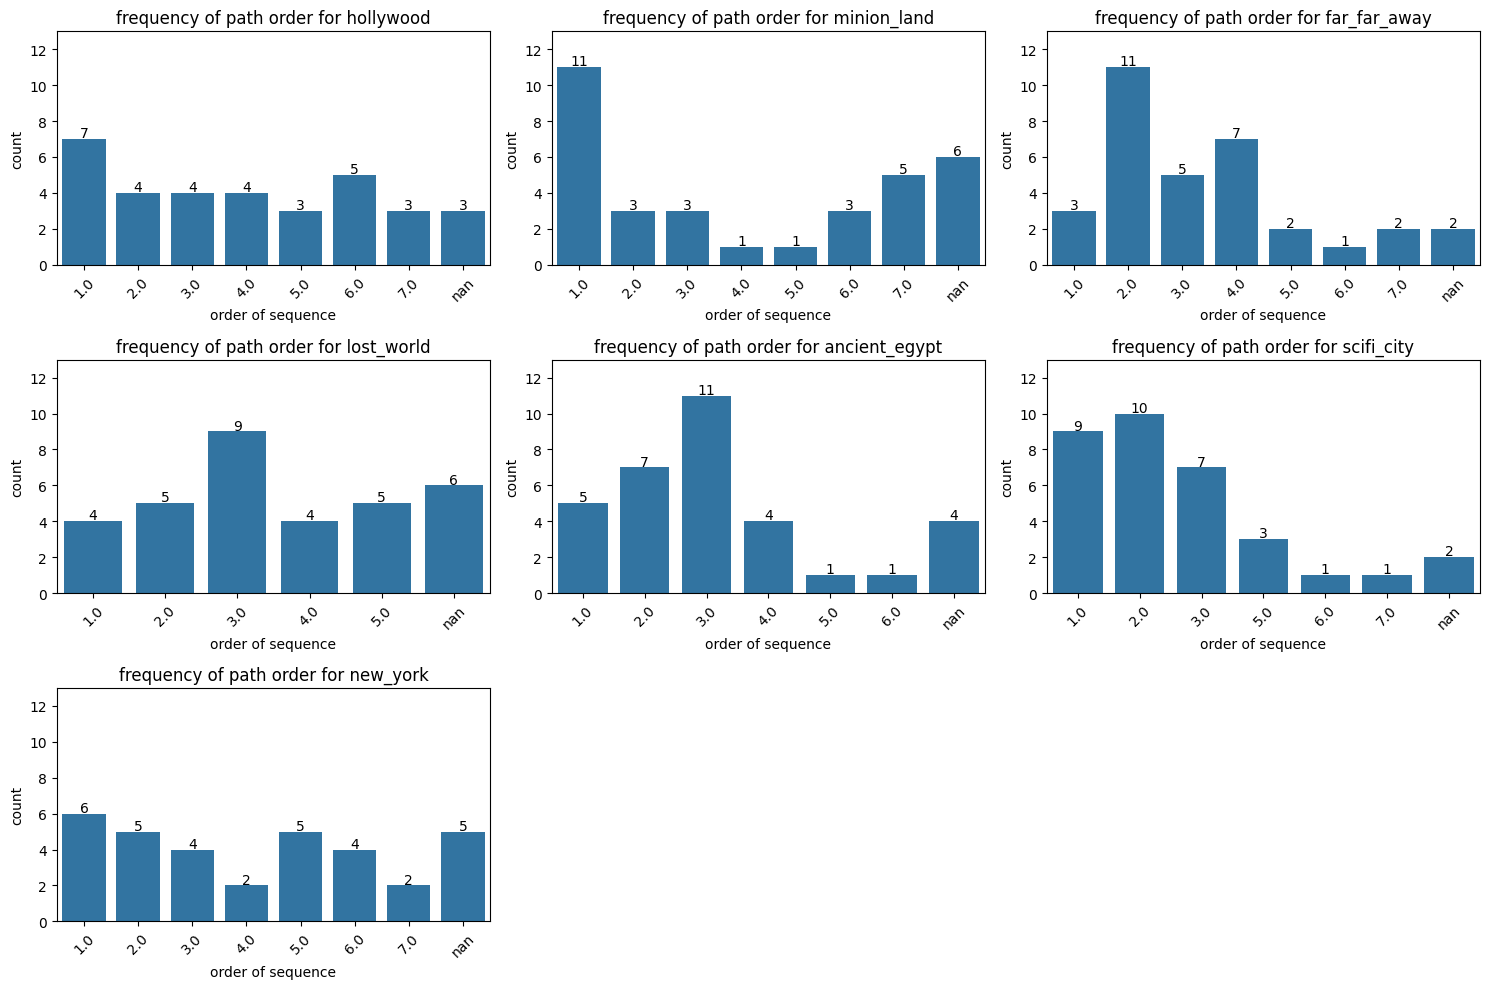

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
df = path_matrix

# Create subplots
num_cols = len(df.columns)
fig, axes = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 10))  # Adjust rows/columns
axes = axes.flatten()

# Generate bar plots
for i, col in enumerate(df.columns):
    counts = df[col].value_counts(dropna=False).sort_index()  # Include NaNs and sort categories
    sns.barplot(x=counts.index.astype(str), y=counts.values, ax=axes[i])
    axes[i].set_ylim(0, 13)
    axes[i].set_title(f"frequency of path order for {col}")
    axes[i].set_xlabel('order of sequence')
    axes[i].set_ylabel("count")
    
    # Add value labels
    for j, v in enumerate(counts.values):
        axes[i].text(j, v + 0.1, str(v), ha='center', fontsize=10)

    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### observations worth observing
- significant people skip lost_world and new_york
- sci-fi and far far away is one of the first few places people visit
- lost world and ancient egypt are usually the 3rd zone to visit - largely the middle of their time in uss
- minion_land is popular as the first attraction to visit, possibly due to its recent opening
- minion_land high na count can be factored in as those who have visited uss before the opening of minion_land


### information of zones

In [4]:
df1 = pd.read_csv('../data/uss_attraction_details/attractions.csv')
df2 = pd.read_csv('../data/uss_attraction_details/rides.csv')
intensity = pd.DataFrame({'intensity':['medium', 'medium', 'high', 'high', 'low', 'medium', 'medium', 'low', 'medium', 'medium', 'low', 'medium', 'high', 'medium', 'medium', 'low', 'high', 'low']})
rides = pd.concat([df1, df2, intensity], axis=1, join='inner')
rides = rides[['Zone', 'ride', 'type', 'environment', 'intensity']]

In [5]:
zone_intensity = rides[['Zone', 'intensity']]
intensity_order = {"high": 3, "medium": 2, "low": 1} #prioritise upper bound as tiebreaker
zone_intensity = zone_intensity.groupby('Zone')['intensity'].agg(lambda x: x.mode()[x.mode().map(intensity_order).argmax()])
print(pd.DataFrame(zone_intensity))

                          intensity
Zone                               
Ancient Egypt                  high
Far Far Away                 medium
Illumination's Minon Land       low
New York                     medium
Sci-Fi City                    high
The Lost World               medium


**HOLLYWOOD HAS NO RIDES SO THEY HAVE NO INTENSITY RATING**

### Sequence Analysis - spmf library

#### by ride intensity preference

In [6]:
high_guests = target_entries[target_entries['ride_pref'] == 'high']
med_guests = target_entries[target_entries['ride_pref'] == 'medium']
low_guests = target_entries[target_entries['ride_pref'] == 'low']
print('high intensity guests: ', high_guests.shape[0], '\nmedium intensity guests: ', med_guests.shape[0], '\nlow intensity guests: ', low_guests.shape[0])

high intensity guests:  16 
medium intensity guests:  12 
low intensity guests:  4


In [7]:
import sequence_mining as sm
high_seq = sm.sequence_mining(high_guests['sequences'])
med_seq = sm.sequence_mining(med_guests['sequences'])
low_seq = sm.sequence_mining(low_guests['sequences'])

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 4 ms
 Frequent sequences count : 63
 Max memory (mb) : 10.960517883300781
 minsup = 5 sequences.
 Pattern count : 63

Post-processing to show result in terms of string values.
Post-processing completed.

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 4 ms
 Frequent sequences count : 68
 Max memory (mb) : 11.455718994140625
 minsup = 4 sequences.
 Pattern count : 68

Post-processing to show result in terms of string values.
Post-processing completed.

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  PREFIXSPAN 0.99-2016 - STATISTICS =============
 Total time ~ 4 ms
 Frequent sequences count : 21
 Max memory (mb) : 11.455718994140625
 minsup = 2 sequences.
 Pattern cou

In [8]:
print(high_seq.sort_values('sup', ascending=False))

                                    pattern  sup
9                            [far_far_away]   16
33                          [ancient_egypt]   16
44                             [scifi_city]   16
58                               [new_york]   16
20                             [lost_world]   15
..                                      ...  ...
49     [scifi_city, far_far_away, new_york]    5
22     [lost_world, hollywood, minion_land]    5
26   [lost_world, ancient_egypt, hollywood]    5
38  [ancient_egypt, far_far_away, new_york]    5
62                [new_york, ancient_egypt]    5

[63 rows x 2 columns]


In [9]:
print(med_seq.sort_values('sup', ascending=False))

                                             pattern  sup
0                                        [hollywood]   11
9                                      [minion_land]   11
61                                      [scifi_city]   11
54                                   [ancient_egypt]   10
32                                    [far_far_away]   10
..                                               ...  ...
36         [far_far_away, lost_world, ancient_egypt]    4
38            [far_far_away, lost_world, scifi_city]    4
39  [far_far_away, lost_world, scifi_city, new_york]    4
41                     [far_far_away, ancient_egypt]    4
34                       [far_far_away, minion_land]    4

[68 rows x 2 columns]


In [10]:
print(low_seq.sort_values('sup', ascending=False))

                                       pattern  sup
13                              [far_far_away]    4
0                                  [hollywood]    3
19                                [scifi_city]    3
3                                [minion_land]    3
5                  [minion_land, far_far_away]    3
12                     [minion_land, new_york]    2
18                             [ancient_egypt]    2
17                                [lost_world]    2
16                  [far_far_away, scifi_city]    2
15               [far_far_away, ancient_egypt]    2
14                  [far_far_away, lost_world]    2
10                [minion_land, ancient_egypt]    2
11                   [minion_land, scifi_city]    2
1                    [hollywood, far_far_away]    2
9                    [minion_land, lost_world]    2
8      [minion_land, far_far_away, scifi_city]    2
7   [minion_land, far_far_away, ancient_egypt]    2
6      [minion_land, far_far_away, lost_world]    2
4           

there is one russian fella that indicated no_rides... what do i do with him/her/them...

### sankey diagram
was maybe a bad idea

In [11]:
# pip install plotly

In [12]:
import plotly.graph_objects as go
from collections import defaultdict

# Your dataset
journeys = ordered_sequences

# Create node labels
unique_places = sorted(set([place for journey in journeys for place in journey]))
node_indices = {place: idx for idx, place in enumerate(unique_places)}

# Create link data
link_counts = defaultdict(int)
for journey in journeys:
    for i in range(len(journey) - 1):
        link_counts[(journey[i], journey[i + 1])] += 1

# Extract source, target, and values
sources = [node_indices[src] for src, tgt in link_counts.keys()]
targets = [node_indices[tgt] for src, tgt in link_counts.keys()]
values = list(link_counts.values())

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=unique_places
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

fig.update_layout(title_text="Theme Park Guest Journey Sankey Diagram", font_size=10)
fig.show()


this graph takes too much braincells to read so lets just not use it